In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [3]:
from numpy import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy
import scipy.optimize
from scipy.optimize import fsolve
import time

atm=1.01325E5
torr=atm/760.0
R=8.3145
g=9.807
NA=6.022e23
def tok(x): return x+273.15


%matplotlib notebook
plt.rcParams['figure.figsize'] = [14,6]
plt.rcParams['figure.dpi'] = 100



# Diffusion från punktkälla (Ficks lag)

<IPython.core.display.Javascript object>


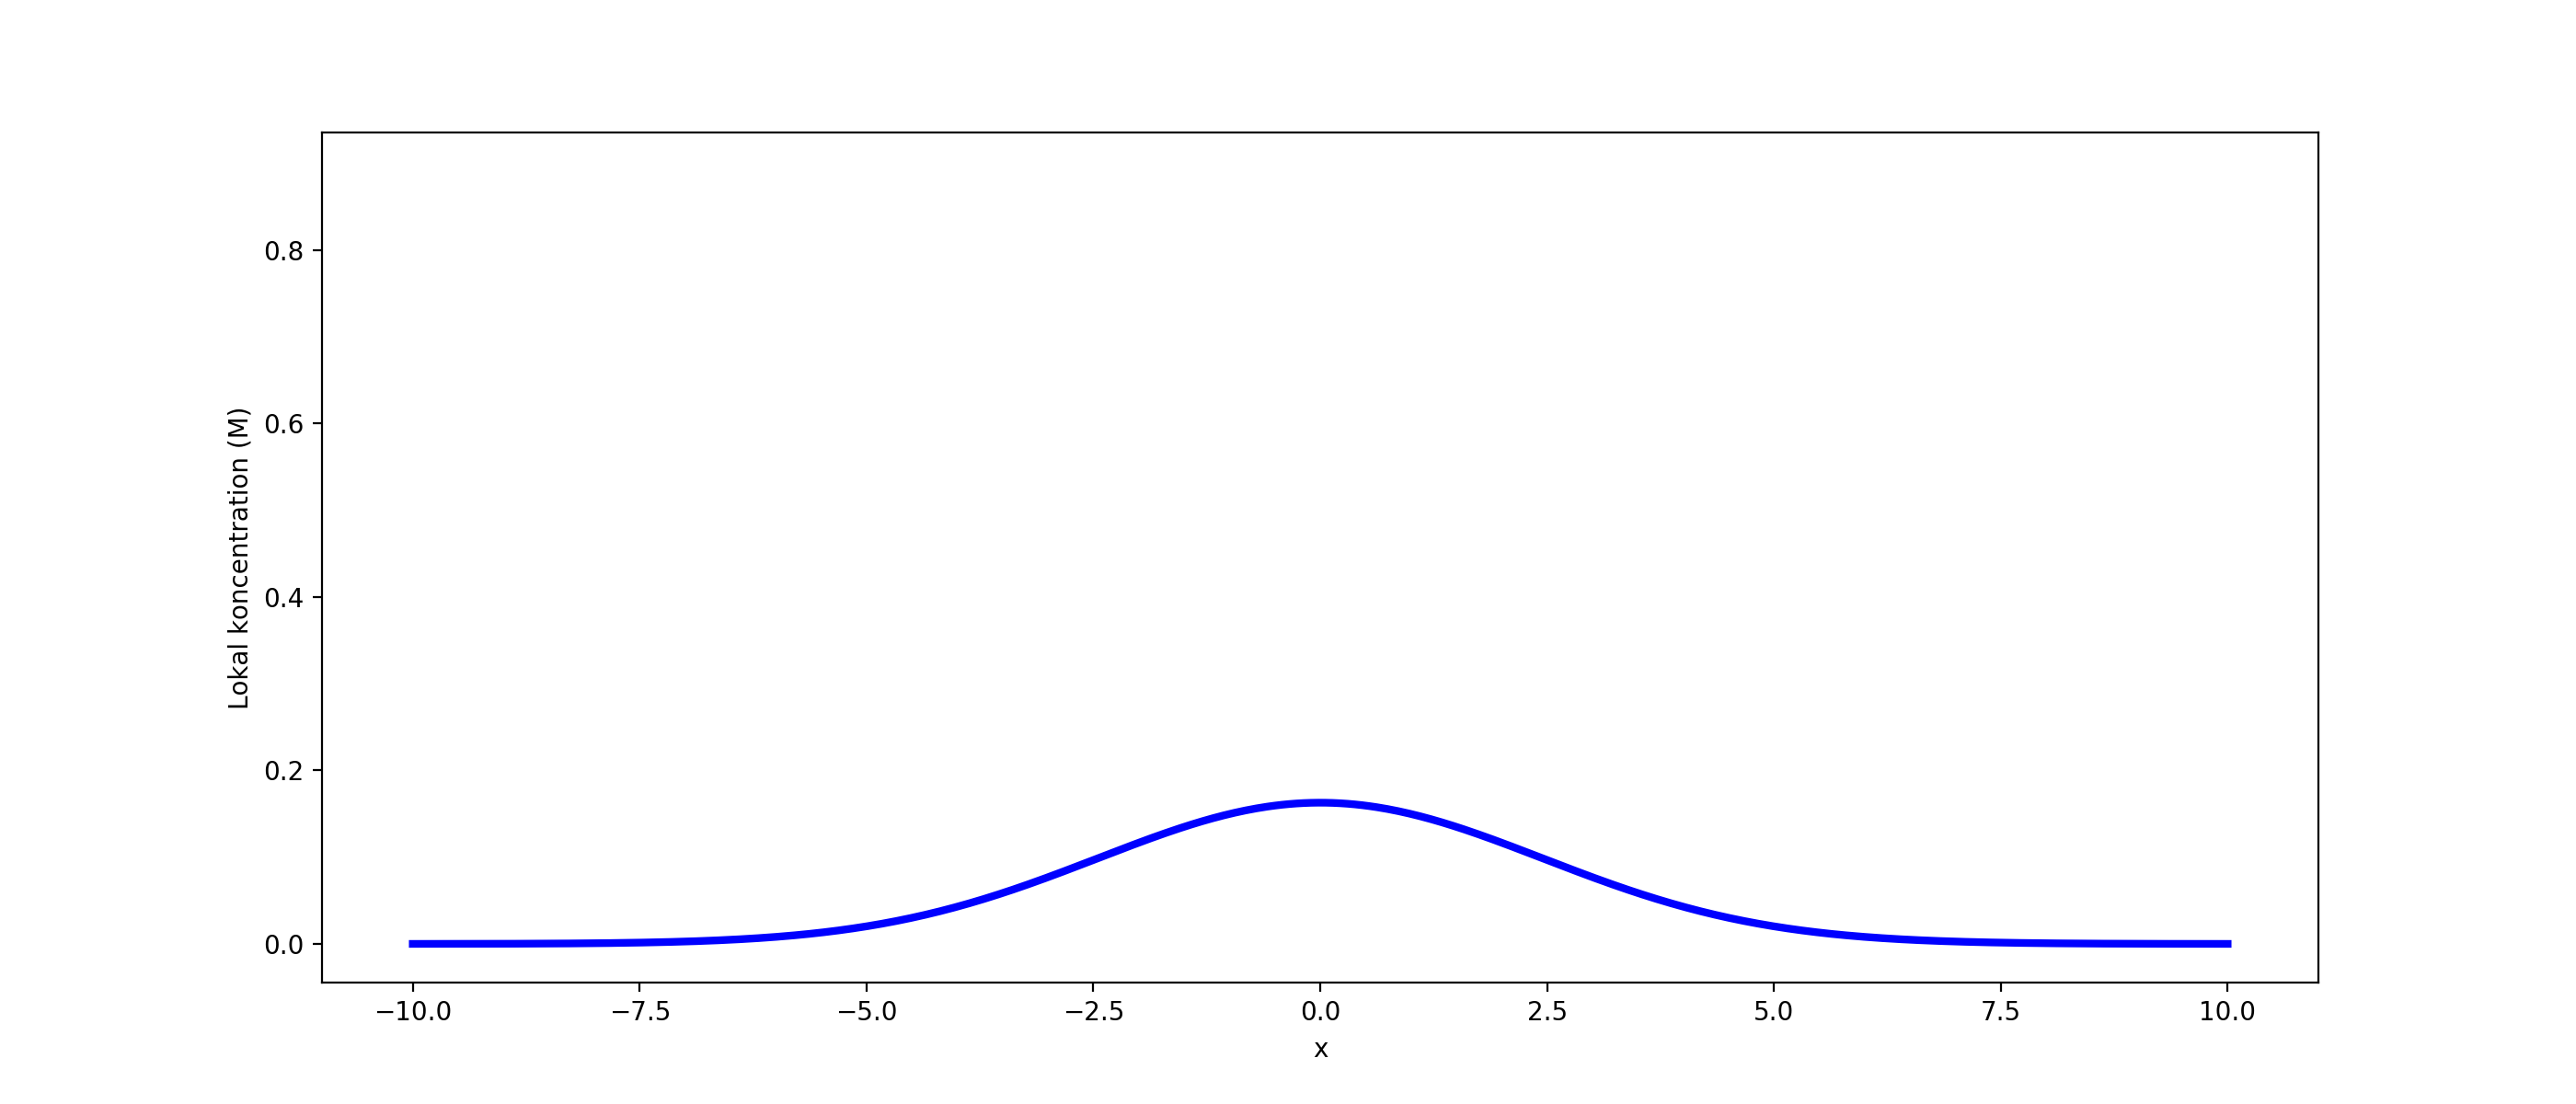

interactive(children=(FloatSlider(value=0.1, description='t', max=4.0, min=0.1, step=0.01), Output()), _dom_cl…

Button(description='Simulera', style=ButtonStyle())

In [5]:
fig = plt.figure()
subfig=fig.add_subplot(111)
plt.xlabel('x')
plt.ylabel('Lokal koncentration (M)')

MAXT=4.0
D=1
X=10
n0=1
v=0
x=linspace(-X,X,500)

def c(x,t): return n0/sqrt(4*pi*D*t)*exp(-(x-v*t)**2/4/D/t)

lineP,=subfig.plot(x,c(x,0.1),'b-',linewidth=3)
    
def update(t):
    lineP.set_ydata(c(x,t))
    fig.canvas.draw_idle()
    fig.canvas.flush_events()

    
def go(b):
    t=slider.value
    while t<MAXT:
        t+=0.1
        lineP.set_ydata(c(x,t))
        slider.value = t
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.05)




slider= widgets.FloatSlider(value=0,
                                               min=0.1,
                                               max=MAXT,
                                               step=0.01)       

widgets.interact(update, t = slider)
button = widgets.Button(description='Simulera',disabled=False)
button.on_click(go)
display(button)


# Brownsk rörelse och jämförelse med Ficks lag

<IPython.core.display.Javascript object>


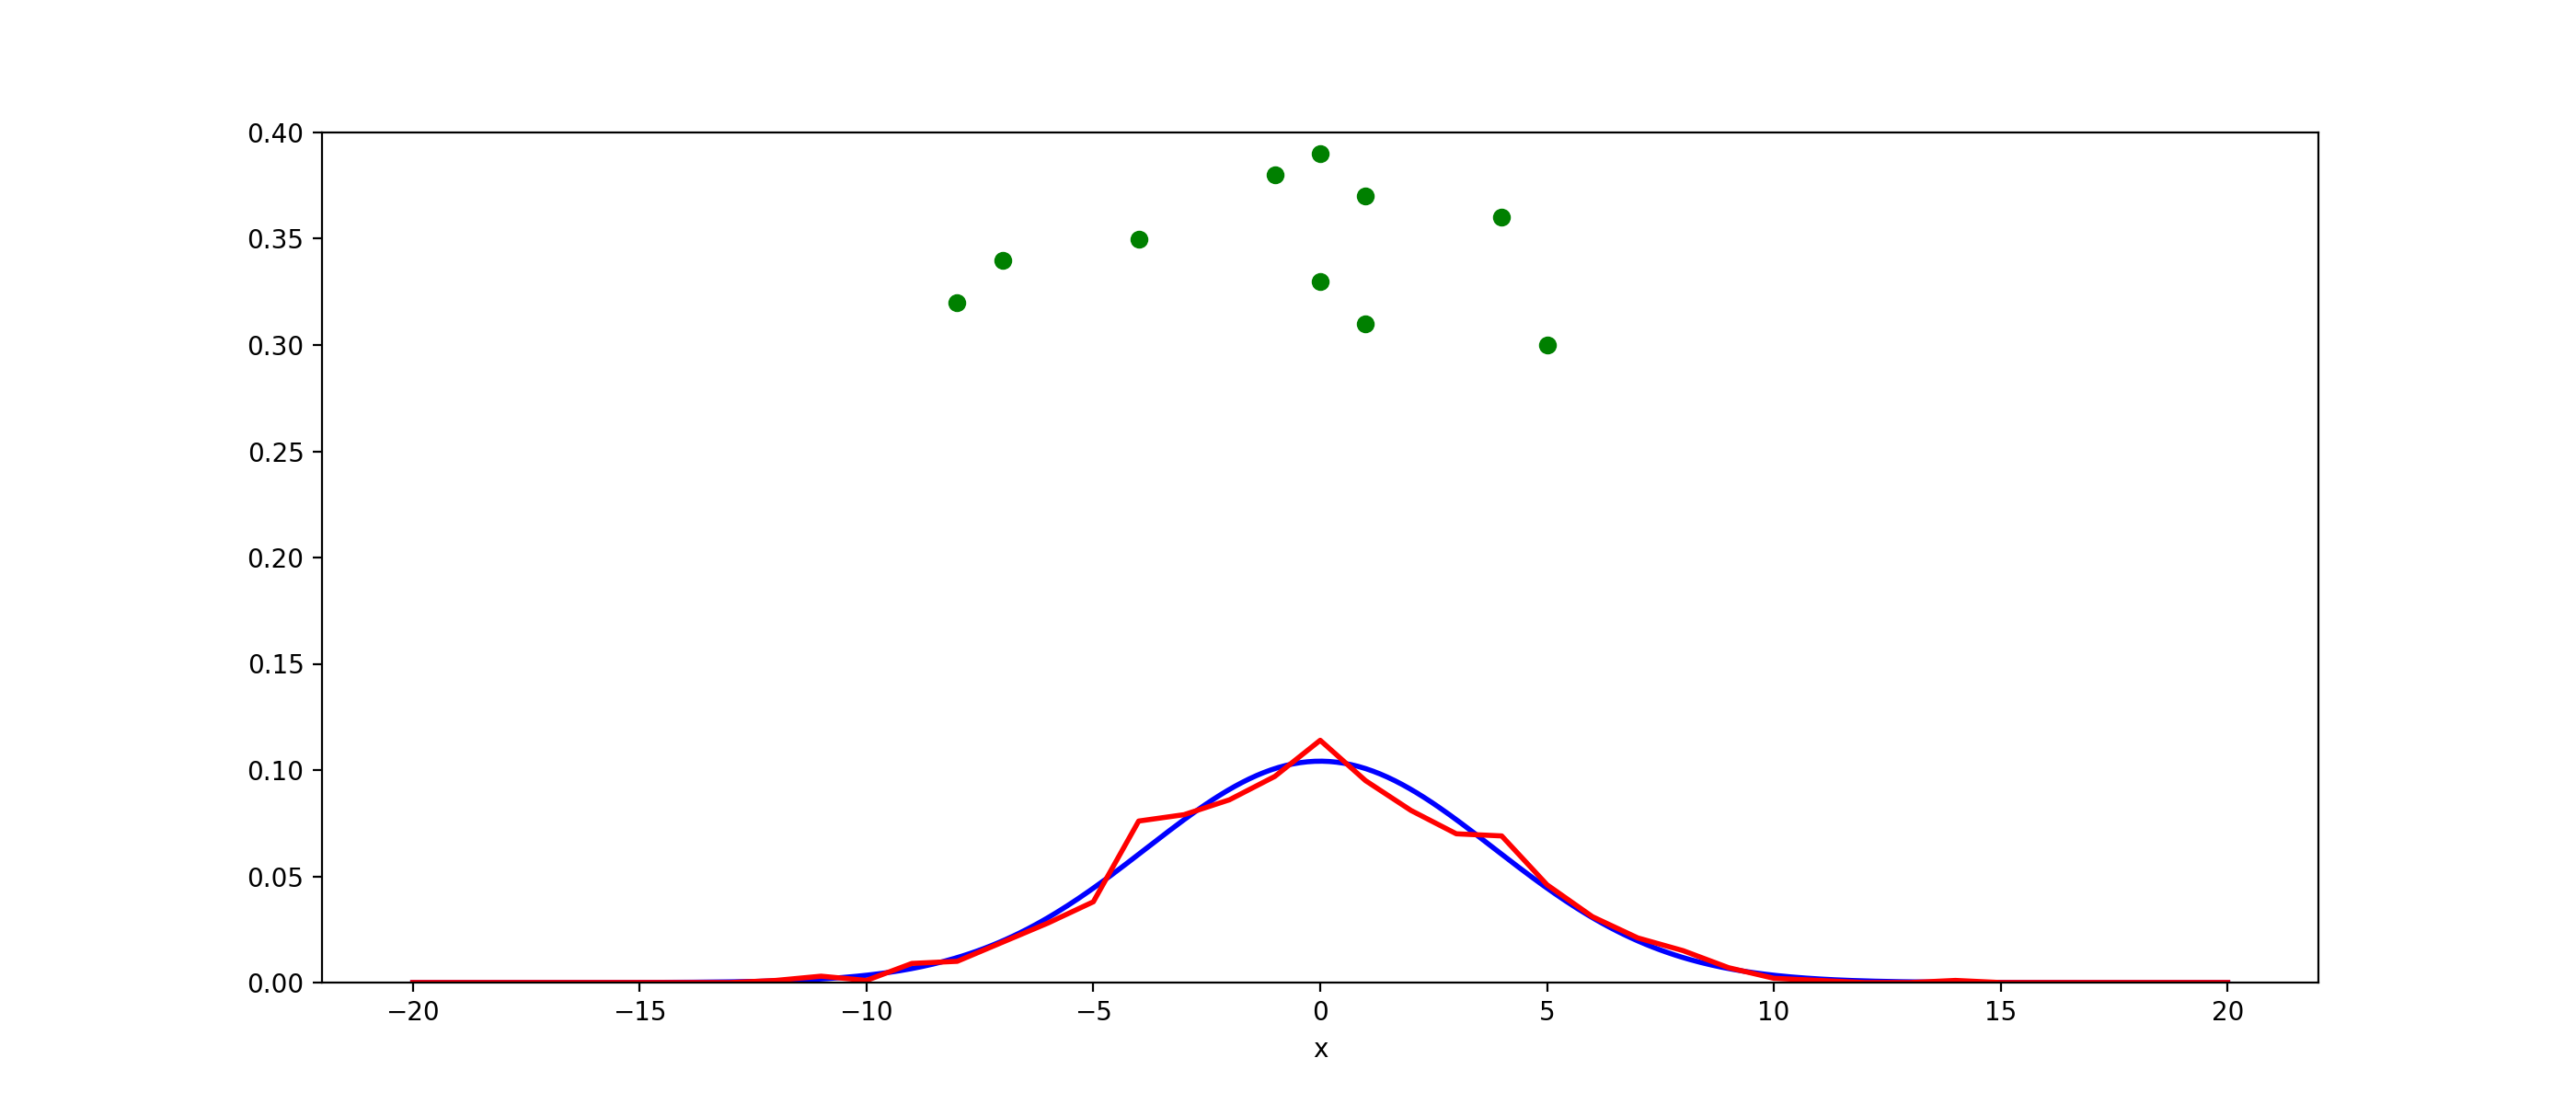

interactive(children=(IntSlider(value=1, description='t', max=80, min=1), Output()), _dom_classes=('widget-int…

Button(description='Simulera', style=ButtonStyle())

Button(description='Stopp', style=ButtonStyle())

Checkbox(value=False, description='Ficks ekvation')

In [6]:
import threading
#import multiprocessing
#Random walk
MAXT=40.0
D=1
X=20
numexamples=10

Nseq=1000
N=round(2*D*MAXT)
w=zeros(Nseq,'i')
bins=arange(-X-0.5,X+0.6)
hist=[]
example=[]
for i in range(N):
    w+=random.randint(-1,2,(Nseq,))         #Tillåt -1, 0, +1
    #w+=random.randint(0,2,(Nseq,))*2-1     #Tillåt -1, +1   (blir taggig linje)
    h,edges = histogram(w, bins=bins,density=True)
    hist.append(h)
    example.append(w[:numexamples].copy())
fig = plt.figure()
subfig=fig.add_subplot(111)
plt.xlabel('x')
plt.ylim(0,0.4)

xvalues=0.5*(bins[:-1]+bins[1:])


v=0
x=linspace(-X,X,500)

def c(x,t): return n0/sqrt(4*pi*D*t)*exp(-(x-v*t)**2/4/D/t)

lineP,=subfig.plot(x,c(x,1/(3*D)),'b-',linewidth=2)
lineW,=subfig.plot(xvalues,hist[0],'r-',linewidth=2) 
lineP.set_visible(False)
dot=[]
for i in range(numexamples):
    dot1,=subfig.plot(example[0][i],0.30+0.01*i,'go')
    dot.append(dot1)

def update(t):
    lineP.set_visible(check.value)
    lineW.set_ydata(hist[t-1])
    lineP.set_ydata(c(x,t/(3*D)))  
    for i in range(numexamples):
        dot[i].set_xdata([example[t-1][i]])
    fig.canvas.draw_idle()
    fig.canvas.flush_events()

stopnow=True

def go(b):
    global stopnow
    if not stopnow:
        print('Already running')
        return
    stopnow=False
    thr = threading.Thread(name='worker', target=simulate)
    thr.start()

def simulate():
    global stopnow
    t=int(slider.value)
    while t<N and not stopnow:
        #print(t)
        t+=1
        slider.value = t
        #fig.canvas.draw()
        time.sleep(0.05)
    stopnow = True
        
def stop(b):
    global stopnow
    stopnow=True


check=widgets.Checkbox(description='Ficks ekvation',value=False)
slider=widgets.IntSlider(value=0,
                                               min=1,
                                               max=N,
                                               step=1)

def redraw(b):
    slider.value=slider.value
    #fig.canvas.draw()

    

widgets.interact(update, t = slider)
button = widgets.Button(description='Simulera',disabled=False)
button.on_click(go)
stopbutton = widgets.Button(description='Stopp',disabled=False)
stopbutton.on_click(stop)

display(button)
display(stopbutton)
display(check)




# Diffusion mot absorberande sfär (t.ex. enzym)

## Första cellen gör själva beräkningarna, kan ta någon minut.

## Andra cellen låter dig simulera förloppet genom att plotta koncentrationen, fluxet och det totala inflödet vid olika tider.

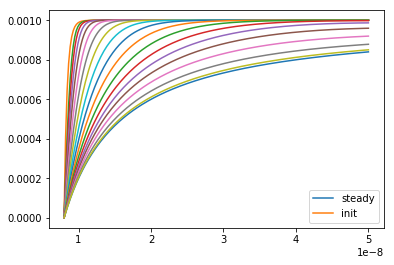

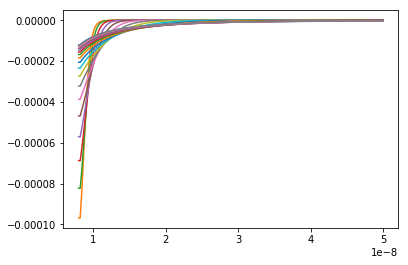

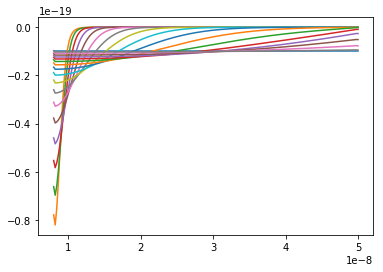

In [5]:
from scipy.interpolate import interp1d
from scipy.misc import derivative
D=1e-10   #m2/s
a=80e-10
cE=1e-3
cS=1e-3
NS=200
r=linspace(80e-10,500e-10,NS)
c=cS*(1-a/r)
cinit=cS*(1-a**20/r**20)

plt.plot(r,c,label='steady')
plt.plot(r,cinit,label='init')

c=cinit
rsafe=r+0.0
rsafe[0]=rsafe[1]
rsafe[-1]=rsafe[-2]

plt.legend()

plt.figure(2)
J=-D*cS*a/r**2
plt.plot(r,J)

I=J*4*pi*r**2   #constant
plt.figure(3)
plt.plot(r,I)



dt=1e-11
cdata=[]
Jdata=[]
Idata=[]
checkpoints=[int(round(10**x)) for x in linspace(1,5,17)]
    
for i in range(100000):
    f=interp1d(r, r*c)
    c += dt * D * 1/r * derivative(f, rsafe, dx=1e-11, n=2)

    if(c[0]<0): c[0]=0
        
    if (i+1) in checkpoints: 
        g=interp1d(r,c)
        J=-D*derivative(g,rsafe,dx=1e-11,n=1)
        I=J*4*pi*r**2
        plt.figure(1)
        plt.plot(r,c)
        plt.figure(2)
        plt.plot(r,J)
        plt.figure(3)
        plt.plot(r,I)
        cdata.append(c+0.0) #Gör en kopia
        Jdata.append(J)
        Idata.append(I)
ka=4*pi*D*a*1000*NA



<IPython.core.display.Javascript object>


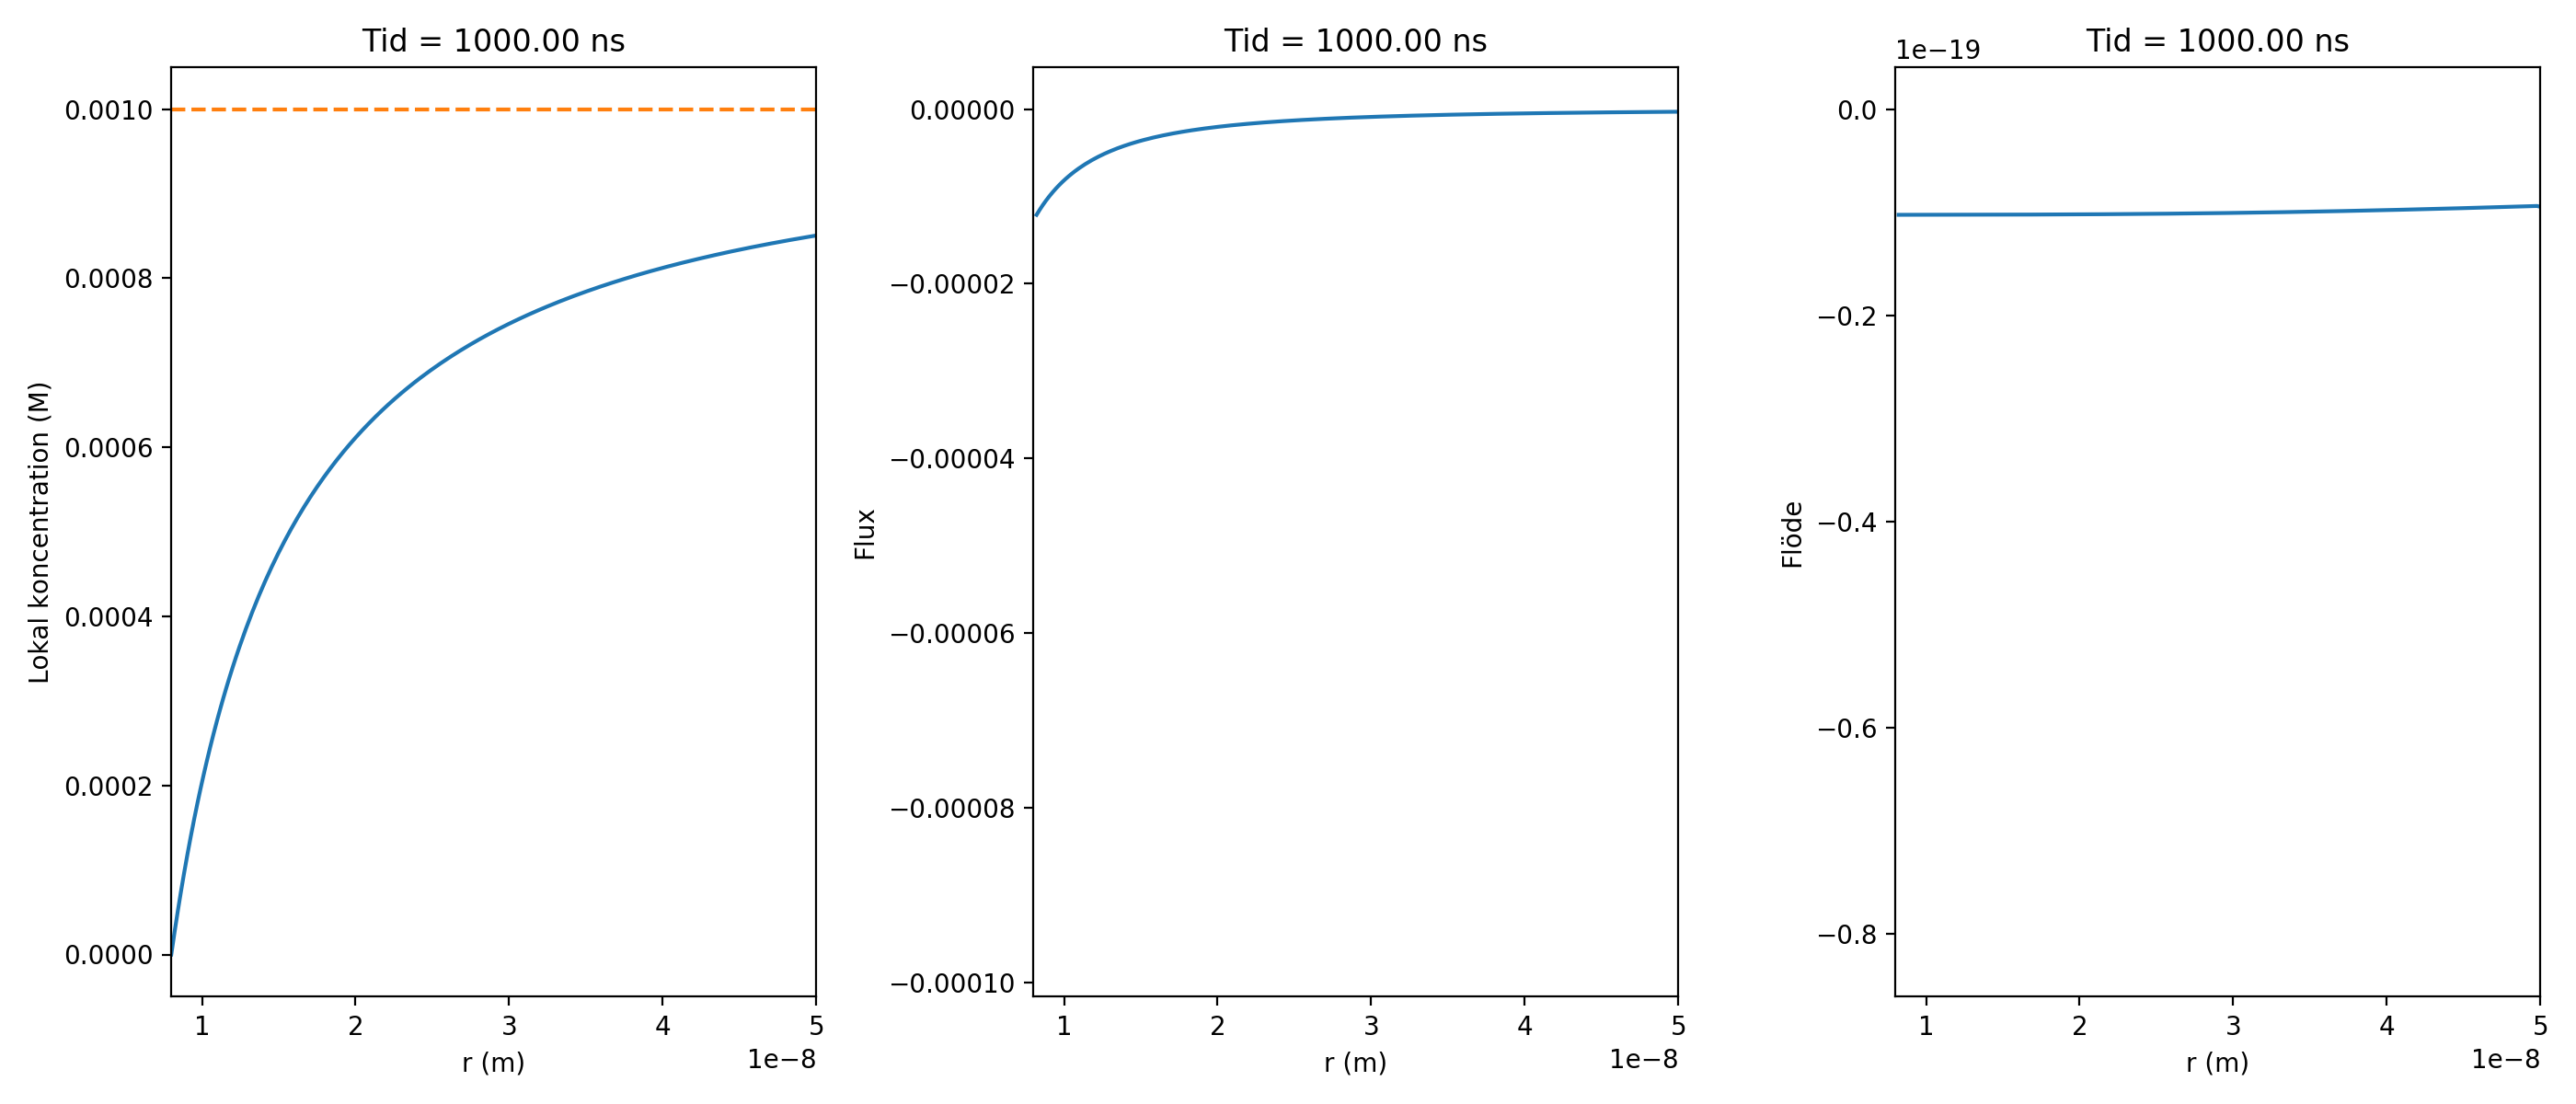

Button(description='Simulera', style=ButtonStyle())

Button(description='Nollställ', style=ButtonStyle())

In [58]:
c=cS*(1-a/r)
J=-D*cS*a/r**2
I=J*4*pi*r**2   #constant

roundnr=0
fig = plt.figure(4)

lineC=0
lineJ=0
lineI=0
#lines.Line2D

tit=[]
def reset(b):
    global roundnr
    global lineC
    global lineJ
    global lineI
    roundnr+=1

    if roundnr==1:
        subfig1=fig.add_subplot(131)
        tit.append(plt.title('Tid = %6.2f ns'%(checkpoints[0]*dt/1e-9)))
        plt.xlim((a,5e-8))

        plt.xlabel('r (m)')
        plt.ylabel('Lokal koncentration (M)')
        lineC,=subfig1.plot(r,cdata[0],label='steady')
        subfig1.plot(r,r*0+cS,linestyle='dashed')
    elif roundnr>1:
        lineC.set_ydata(cdata[0])
    if roundnr==2:
        subfig2=fig.add_subplot(132)
        tit.append(plt.title('Tid = %6.2f ns'%(checkpoints[0]*dt/1e-9)))
        plt.xlim((a,5e-8))
        plt.xlabel('r (m)')
        plt.ylabel('Flux')
        lineJ,=subfig2.plot(r[1:],Jdata[0][1:],label='steady')
    elif roundnr>2:
        lineJ.set_ydata(Jdata[0][1:])
    if roundnr==3: 
        subfig3=fig.add_subplot(133)
        tit.append(plt.title('Tid = %6.2f ns'%(checkpoints[0]*dt/1e-9)))
        plt.xlim((a,5e-8))
        plt.xlabel('r (m)')
        plt.ylabel('Flöde')
        lineI,=subfig3.plot(r[1:],Idata[0][1:],label='steady')

    fig.tight_layout()
    
    plt.show()

def go(b):
    global lineC
    global lineJ
    global lineI

    
    for i in range(1,len(cdata)):
        for t in tit: t.set_text('Tid = %6.2f ns'%(checkpoints[i]*dt/1e-9))
        lineC.set_ydata(cdata[i])
        if roundnr>=2: lineJ.set_ydata(Jdata[i][1:])
        if roundnr>=3: lineI.set_ydata(Idata[i][1:])
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.3)


    

reset(0)
button = widgets.Button(description='Simulera',disabled=False)
button.on_click(go)
button2 = widgets.Button(description='Nollställ',disabled=False)
button2.on_click(reset)
display(button)
display(button2)




